<center>

# Trabajo Práctico Final

## Procesamiento de imágenes biomédicas

### Primer Cuatrimestre 2024

</center>

**Docentes:**

- Roberto Sebastián Tomás
- Aylin Agatha Vazquez Chenlo
- Francisco Tassara

**Alumnxs:**

- Bajle, Ivo - 62175
- Grau, Gonzalo - 62259
- Pereira, Camila Noemi - 61574

### Objetivo del trabajo

El objetivo del presente trabajo es desarrollar un algoritmo para investigar la translucencia nucal en la etapa gestacional a partir de imágenes de ultrasonido. Este proyecto se llevará a cabo utilizando los conocimientos adquiridos en las clases teóricas de la materia. Al crear un algoritmo capaz de medir la translucencia nucal con la mayor precisión posible, se pretende obtener una comprensión más profunda y proporcionar herramientas precisas para el diagnóstico temprano de anomalías cromosómicas y otros problemas fetales. Los resultados de este estudio podrían contribuir significativamente al campo de la obstetricia. 

### Estado del arte 

En 1985, se descubrió la conexión entre el incremento del pliegue nucal en fetos del segundo trimestre y las alteraciones cromosómicas. En el primer trimestre, se observó una asociación similar y se introdujo el término “translucencia nucal” (TN) para describir la región sonoluscente en la parte posterior de la nuca fetal. Estudios realizados en gestantes de alto riesgo confirmaron esta relación. 

Inicialmente, la TN se evaluaba utilizando un punto de corte fijo. Sin embargo, se observó que la TN aumentaba con la edad gestacional, lo que llevó a la adopción de una curva de valores de referencia en función de la longitud cefalocaudal (LCC). Posteriormente, se desarrolló un modelo matemático que combinaba el riesgo asociado a la TN con la edad materna y los marcadores bioquímicos, dando lugar al método de cribado combinado. Este método resultó ser más eficaz y coste-eficiente que el cribado bioquímico en el segundo trimestre. 

En la práctica clínica rutinaria, se ha comprobado que es posible obtener resultados similares, siempre y cuando se respeten estrictamente las técnicas de medición y los controles de calidad.

Entre la semana 11 y 14 de gestación, todos los fetos desarrollan una colección de líquido en la nuca, visible ecográficamente. El incremento de TN se asocia con edema nucal que puede ser producto de diversas patologías. Las teorías propuestas incluyen fallo cardiaco, congestión venosa, alteraciones en la matriz extracelular y desarrollo anormal del sistema linfático. Después de la semana 14, el sistema linfático se desarrolla lo suficiente para drenar cualquier colección de líquido, por lo que la desaparición del incremento TN no debe interpretarse como un hallazgo tranquilizador.

Para medir la TN, se debe seguir la técnica estándar de la Fetal Medicine Foundation (FMF):
- Realizar la medición cuando la LCC del feto esté entre 45 y 84 mm (semanas 11 a 13+6 días).
- Usar un ecógrafo de alta resolución, preferentemente por vía abdominal. Cuando no sea factible se puede optar por la vía transvaginal.
- La medición debe realizarse en la visión sagital del embrión, con el feto en posición natural y la cabeza alineada con la columna.
- La imagen embrionaria debe estar ampliada de manera que incluya solamente la cabeza fetal y la parte superior del tórax.
- La medición debe realizarse en la zona más ancha de la TN y deben tomarse tres mediciones, quedando como válida la mayor de las tres.
- Para evitar confusiones, se debe diferenciar la línea generada por la membrana amniótica de la correspondiente a la piel fetal y evitar que el cordón umbilical se posicione  alrededor del cuello fetal. 



##### Lo anterior lo saque de aca: https://www.elsevier.es/es-revista-clinica-e-investigacion-ginecologia-obstetricia-7-articulo-translucencia-nucal-13074916 

### Base de datos

Para realizar nuestro trabajo, adquirimos las imágenes necesarias disponibles en el siguiente enlace: https://data.mendeley.com/datasets/n2rbrb9t4f/1. Esta base de datos contiene 1528 imágenes de ultrasonido en vista sagital 2D, recolectadas del Shenzhen People's Hospital de 1519 gestantes. Además, incluye 156 imágenes adicionales provenientes del hospital filial de Longhua del Shenzhen People's Hospital.  

### Desarrollo

Se comienza enunciando todas las librerías con las que se trabajaron en el desarrollo de algoritmo.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from my_img_processor import My_Image
import matplotlib as mpl
import cv2
from scipy.ndimage import label

In [10]:
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'black'
plt.style.use('dark_background')

Se visualiza la imagen de ultrasonido con la que se va a trabajar. Por lo tanto, para todo lo enunciado a posterior, elegimos la imagen 1426.png.

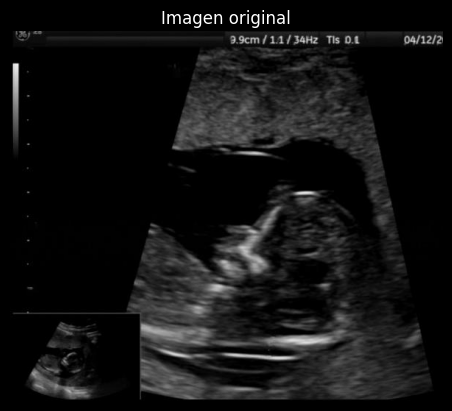

In [11]:
img_path = r'Dataset for Fetus Framework\Dataset for Fetus Framework\External Test Set\Standard\1426.png'
raw_img = My_Image(img_path)

fig_raw, ax_raw = plt.subplots()
ax_raw.imshow(raw_img, vmin=0, vmax=255, cmap='gray')
ax_raw.set_title('Imagen original')
plt.axis('off')
plt.show()

Se tiene un gráfico interactivo, que detecta los puntos que seleccionas dentro de la imagen y los guarda en variables globales (x,y). Estos puntos se van ubicar en el área que se va a utilizar para medir la TN. 

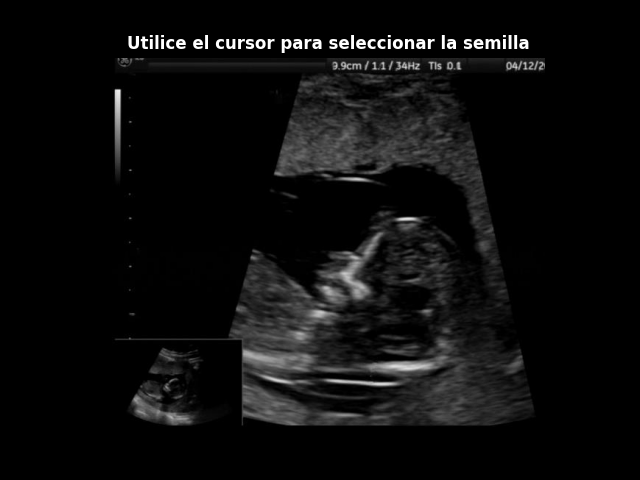

x=345, y=434
x=267, y=434


In [12]:
%matplotlib widget
x, y = 330, 370
def interactive_plot(img):
   plt.ion()
   fig, ax = plt.subplots()
   fig.canvas.set_cursor(mpl.backend_tools.Cursors.SELECT_REGION)
   ax.set_title('Utilice el cursor para seleccionar la semilla', fontweight='bold')
   def onclick(event):
      global x
      global y
      x = int(np.ceil(event.xdata))
      y = int(np.ceil(event.ydata))
      print(f"{x=}, {y=}")
      ax.plot(x, y, marker='x', color='yellow')
      ax.figure.canvas.draw()
      fig.canvas.set_cursor(mpl.backend_tools.Cursors.SELECT_REGION)

   ax.imshow(img, vmin=0, vmax=255, cmap='gray')
   plt.axis(False)
   fig.canvas.mpl_connect('button_press_event', onclick)
   plt.show()

interactive_plot(raw_img)

Una vez que se encuentran seleccionados los puntos, se cierra el gráfico interactivo.

In [13]:
plt.close()
%matplotlib inline

Para poder obtener el área para medir la TN, se desarrollaron tres tipos de segmentación: Segmentación por contraste, etiquetado y region growing.

##### 1) Segmentación por contraste

Se binariza la imagen utilizando el punto medio de histograma ecualizado.

In [14]:
eq_img = raw_img.equalize_hist()

In [15]:
bin_img = np.zeros_like(raw_img)
THRES = 255//2
for i in range(bin_img.shape[0]):
    for j in range(bin_img.shape[1]):
        if eq_img[i, j] > THRES:
            bin_img[i, j] = 255

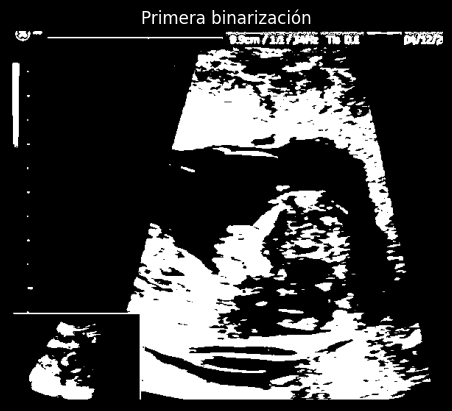

In [16]:
fig_bin, ax_bin = plt.subplots()
ax_bin.imshow(bin_img, vmin=0, vmax=255, cmap='gray')
ax_bin.set_title('Primera binarización')
plt.axis(False)
plt.show()

Al observar la imagen, se puede presenciar ruido de tipo sal y pimienta en ella. Es por eso, que se busca eliminar este ruido de la imagen.

In [17]:
sp_img = bin_img.median_filter(5)

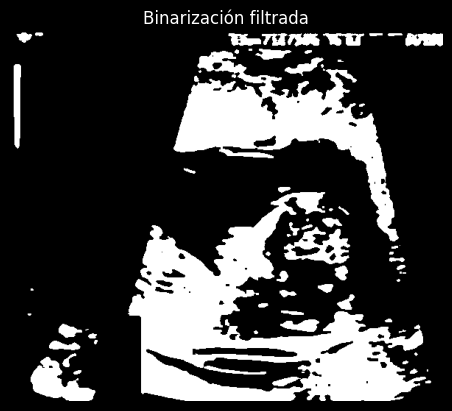

In [18]:
fig_sp, ax_sp = plt.subplots()
ax_sp.imshow(sp_img, vmin=0, vmax=255, cmap='gray')
ax_sp.set_title('Binarización filtrada')
plt.axis(False)
plt.show()

Con la imagen que se obtenien luego del pasaje por el filtro, utilizando el punto que elegimos en la grafica interactiva, segmentamos el area.

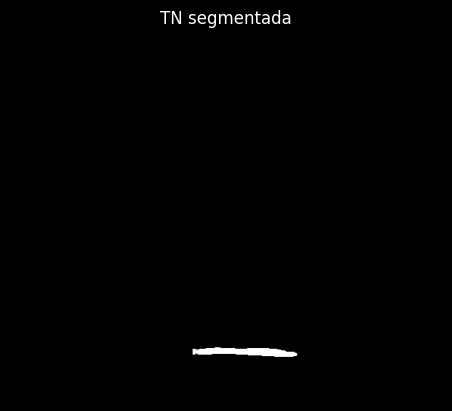

In [19]:
img_sitk = sitk.GetImageFromArray(sp_img)
img_seg = sitk.ConnectedThreshold(img_sitk, seedList=[(x, y)])
img_seg = My_Image(sitk.GetArrayFromImage(img_seg))

fig_seg, ax_seg = plt.subplots()
ax_seg.imshow(img_seg, vmin=0, vmax=1, cmap='gray')
ax_seg.set_title('TN segmentada')
plt.axis(False)
plt.show()

Respecto al área que se obtiene, utilizando un filtro kernel, se obtiene el borde que esta tiene.

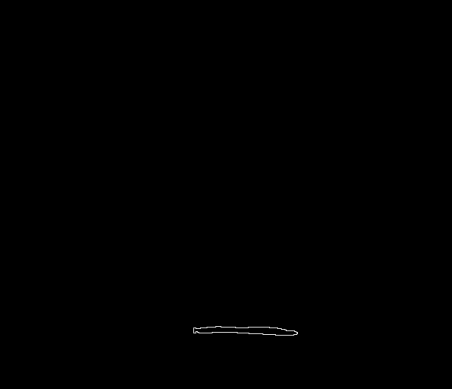

In [22]:
img_seg[img_seg > 0] = 255
KL1 = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
border_seg1 = img_seg.filter_w_kernel(KL1)
plt.imshow(border_seg1, vmin=0, vmax=255, cmap='gray')
plt.axis('off')
plt.show()

#### 2) Etiquetado

Luego de que se seleccione el punto en el gráfico interactivo, y antes de aplicarle a la imagen la función de etiquetado. Como va a ocurrir luego en la segmetacion por region growing, la imagen se binariza por Otsu.
Una vez hecha la binarizacion, se realiza el etiquetado de la imagen y además se va a poder visualizar su histograma.

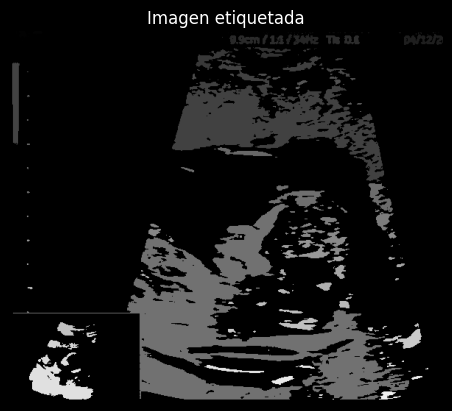

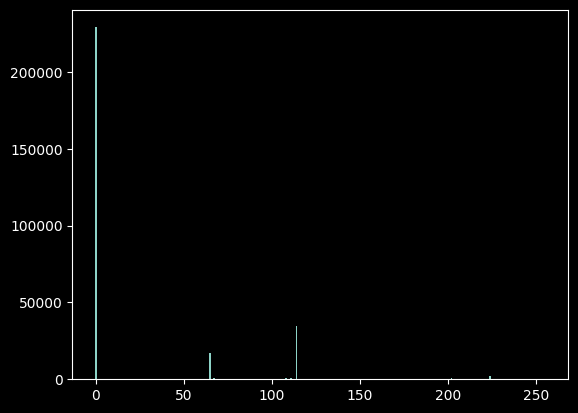

In [24]:
# Etiquetamos
imagen_binaria = raw_img.binarizar_otsu()
imagen_etiquetada, num_features = imagen_binaria.etiquetar_componentes()

plt.imshow(imagen_etiquetada, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.title('Imagen etiquetada')
imagen_etiquetada.get_hist(plot=True);


Para extraer el area de la imagen por etiquetado, primero se invierten los valores de intesidad y luego utilizando la intensidad del punto que se seleccionó se van tomando todos los puntos de su alrededor con la misma intensidad hasta que encuentra otro de valor diferente, ese es el limite.

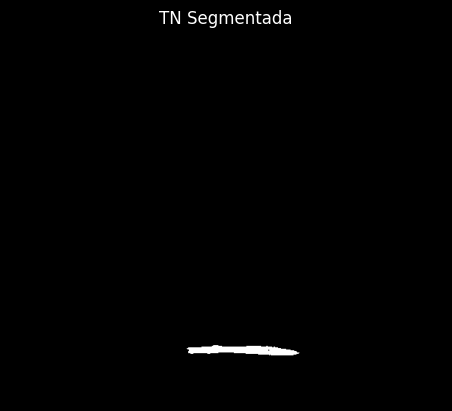

In [25]:
# Invertimos y extraemos la seccion
imagen_invertida = imagen_etiquetada.invertir_imagen()
#Definir el punto 
punto = (x, y)
#Extraer el area
area_extraida = imagen_invertida.extraer_area_por_intensidad(punto)

plt.imshow(area_extraida, vmin=0, vmax=255, cmap='gray')
plt.axis(False)
plt.title('TN Segmentada')
plt.show()

Como hay presencia de ruido sal pimienta, pasamos la imagen obtenida por el filtro de mediana que lo elimina y obtenemos al igual que en el anterior caso, el borde del área.

Text(0.5, 1.0, 'Aplicamos sal y pimienta')

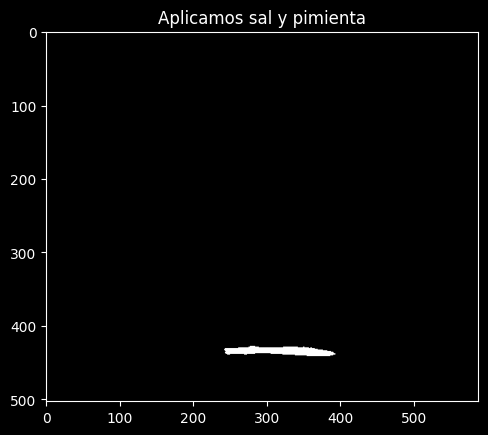

In [27]:
# Aplicamos sal y pimienta
area_extraida_limpia = area_extraida.median_filter(window_size=3)
plt.imshow(area_extraida_limpia, vmin=0, vmax=255, cmap='gray')
plt.title('Aplicamos sal y pimienta')


In [38]:
# Hallamos el borde
KL1 = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
border_seg2 = area_extraida_limpia.filter_w_kernel(KL1)

#### 3) Region growing

Para este método de segmentación, se trabaja particularmente con dos puntos, el primero es el punto semilla y el segundo va a ser utilizado para calcular una distacia máxima que va a servir para limitar el área.
Antes de aplicar el region growing, la imagen se binariza utilizando otsu. 

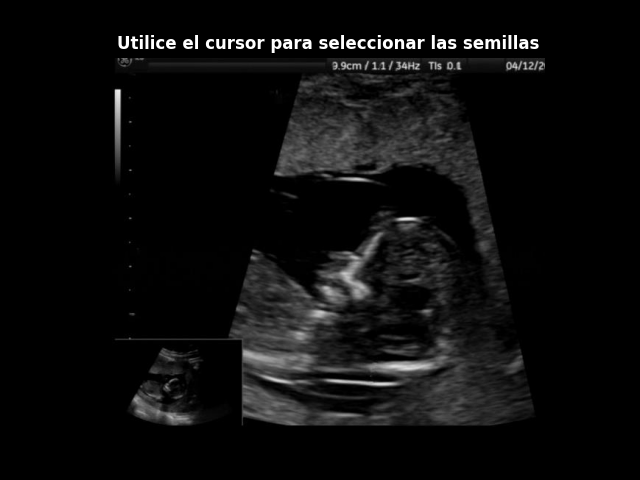

x=337, y=432
x=266, y=435


In [32]:
%matplotlib widget
x, y = (345, 369)
x_y_vals = []
def interactive_plot(img):
   plt.ion()
   fig, ax = plt.subplots()
   fig.canvas.set_cursor(mpl.backend_tools.Cursors.SELECT_REGION)
   ax.set_title('Utilice el cursor para seleccionar las semillas', fontweight='bold')

   def onclick(event):
      global x
      global y
      global x_y_vals
      x = int(np.ceil(event.xdata))
      y = int(np.ceil(event.ydata))
      x_y_vals.append((x, y))
      print(f"{x=}, {y=}")
      ax.plot(x, y, marker='x', color='yellow')
      ax.figure.canvas.draw()
      fig.canvas.set_cursor(mpl.backend_tools.Cursors.SELECT_REGION)

   ax.imshow(img, vmin=0, vmax=255, cmap='gray')
   plt.axis(False)
   fig.canvas.mpl_connect('button_press_event', onclick)
   plt.show()

interactive_plot(raw_img)

In [33]:
plt.close()
%matplotlib inline

In [34]:
#Calcular la distancia
def calcular_distancia(punto1, punto2):
    return np.sqrt((punto1[0] - punto2[0])**2 + (punto1[1] - punto2[1])**2)


img = My_Image(img_path)
imagen_binaria = img.binarizar_otsu()

#Definir la semilla para el crecimiento 
seed_point = x_y_vals[-2]

#Definir el segundo punto para calcular la distancia máxima
second_point = x_y_vals[-1]  

max_distance = calcular_distancia(seed_point, second_point)
segmented_image = imagen_binaria.region_growing(seed_point, thresh=10, max_dist=max_distance)
cv2.imwrite('imagen_rg.png', segmented_image)
cv2.imshow('Imagen RG', segmented_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Al igual que en el anterior tipo de segmentacion a partir del área que se obtiene, extraemos su correspondiente borde.

In [35]:
# Hallamos el borde
segmented_image[segmented_image > 0] = 255
KL1 = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
border_seg3 = segmented_image.filter_w_kernel(KL1)

Con los bordes que se obtuvieron en los tres tipos de segmentacion y haciendo uso de la figura de una elipse, se calcula la TN. La elipse con su eje mayor representa el ancho de las áreas obtenidas y su eje menor es el que representa el valor de la TN.

#### 1) Segmentación por constraste

c:\Users\user\OneDrive\Desktop\PIB TP\TP_PSIB\TP PIB\my_img_processor.py:356: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  p = np.linalg.lstsq(A, b)[0].squeeze()


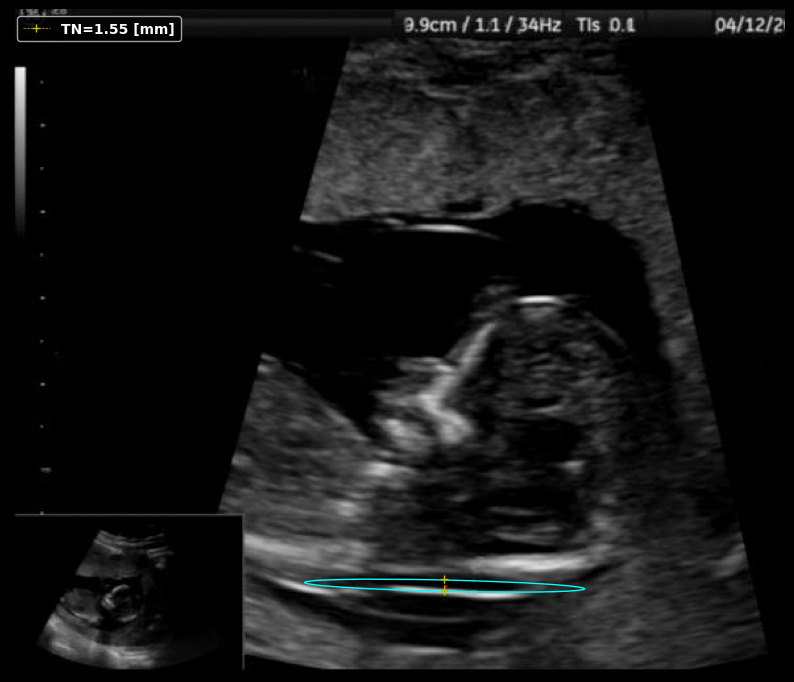

In [29]:
c = (500 - 23)/82
1/c
ellipse_patch = border_seg1.fit_ellipse()
raw_img.plot_with_ellipse(ellipse_patch, c)

#### 2) Etiquetado

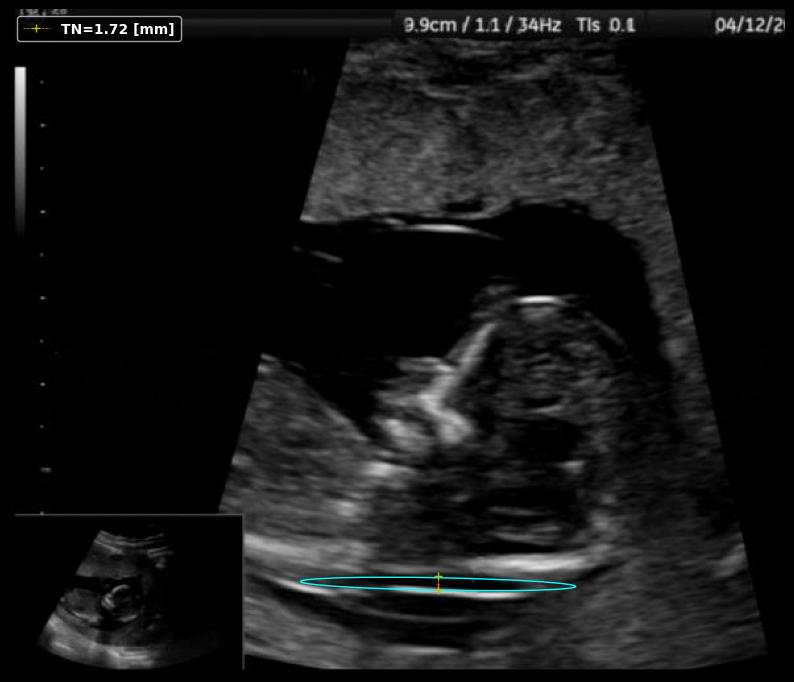

In [39]:
# Fitteamos la elipse nuevamente
ellipse_patch = border_seg2.fit_ellipse()
raw_img.plot_with_ellipse(ellipse_patch, c=1/0.1719077568134172)

#### 3) Region growing 

c:\Users\user\OneDrive\Desktop\PIB TP\TP_PSIB\TP PIB\my_img_processor.py:356: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  p = np.linalg.lstsq(A, b)[0].squeeze()


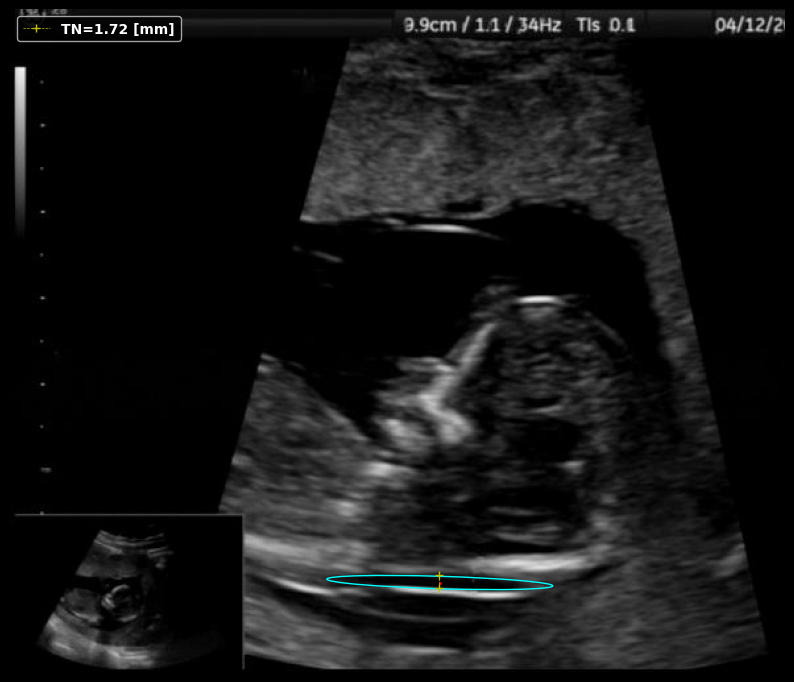

In [36]:
# Fitteamos la elipse nuevamente
ellipse_patch = border_seg3.fit_ellipse()
plt.close()
raw_img.plot_with_ellipse(ellipse_patch, c=1/0.1719077568134172)

Los valores de TN que se consideran normales se encuentran en el rango de 2,5 a 3 mm de grosor. Si los valores superan dicho rango, significa que estamos en presencia de TN aumentada.
Link: https://nace.igenomix.es/blog/translucencia-nucal-embarazo/#:~:text=En%20concreto%2C%20las%20medidas%20de,que%20afecten%20a%20su%20desarrollo.